Mapping from David's labels to ours

Modelling = in silico
Other = others (but maybe one is a superset of the other given the additional categories, especially experimental (in vivo/vitro))
Meta analysis = meta_study + RCT_review
Randomized controlled trial = RCT
Non-randomized trial = controlled_trial_non_randomised
Prospective observationion + Retrospective cohort + Time-series analysis + Case-control + Cross-sectional + Case Study = comparative_study + descriptive_study = observational study
No map = in_vitro
No map = in_vivo

['Other',
 'Meta analysis',
 'Randomized control trial',
 'Non-randomized trial',
 'Prospective cohort',
 'Time-series analysis',
 'Retrospective cohort',
 'Cross-sectional',
 'Case control',
 'Case study',
 'Simulation']

In [36]:
from common.logging import create_logger
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
from datasets import single_label_multiclass_annotated_study_design, enrich_annotations, annotations_with_specter_embeddings, coronawhy_annotated_study_design
from classifier import train_validate_catboost_model
from catboost import CatBoostClassifier, Pool
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = Path('/media/wwymak/Storage/coronawhy/nlp_datasets')
annotations_filepath =Path(data_dir/'Study_Design_Annotation_Snapshot_4_12_20.csv')
metadata_filepath   = data_dir/'metadata.csv.zip'

annotations_coronawhy = coronawhy_annotated_study_design(annotations_filepath, metadata_filepath)
annotations_coronawhy.head()

,cord_uid,title,abstract,label,label_string
0,480bzpi1,Do we have enough evidence how seasonal influe...,Abstract Purpose To identify if there is enoug...,8,meta_study
1,y8z0pwgn,A permanent host shift of rabies virus from Ch...,Bat virus host shifts can result in the spread...,0,in_silico
2,cxwucrgo,Structural maturation of rubella virus in the ...,Abstract Rubella virus is a small enveloped vi...,1,in_vitro
3,u4mvk89w,X-Ray Structure and Inhibition of 3C-like Prot...,Porcine epidemic diarrhea virus (PEDV) is a co...,1,in_vitro
4,ff9vfrvc,Impact of SARS on healthcare utilization by di...,Abstract Objective To assess the impact of the...,7,descriptive_study


In [15]:
colname_to_number_mapping = {
        k: idx for idx, k in enumerate(['in_silico', 'in_vitro',
                           'in_vivo', 'RCT_review', 'RCT', 'controlled_trial_non_randomised',
                           'comparative_study', 'descriptive_study', 'meta_study'])
    }
colname_to_number_mapping

{'in_silico': 0,
 'in_vitro': 1,
 'in_vivo': 2,
 'RCT_review': 3,
 'RCT': 4,
 'controlled_trial_non_randomised': 5,
 'comparative_study': 6,
 'descriptive_study': 7,
 'meta_study': 8}

In [ ]:
# key = our name, value = david's label
coronawhy_to_david_mapping = {
    'in_silico': 9,
    'in_vitro':0,
 'in_vivo':0,
 'RCT_review': 3,
 'RCT': 2,
 'controlled_trial_non_randomised': 3,
 'comparative_study': 6,
 'descriptive_study': 7,
 'meta_study': 1
}

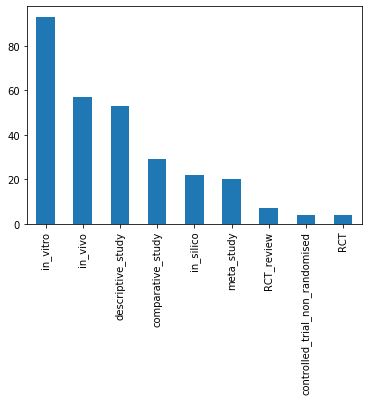

In [3]:
annotations_coronawhy.label_string.value_counts().plot.bar()

In [19]:
# load trained catboost model
cb_model = CatBoostClassifier().load_model(str(data_dir/'catboost_david_annotation_2_may'))

In [30]:
test_pool =  Pool(
            annotations_coronawhy[['title', 'abstract']],
            feature_names=['title', 'abstract'],
            text_features=['title', 'abstract'])
predictions = cb_model.predict(test_pool)
probabilities = cb_model.predict_proba(test_pool)

In [32]:
# david's mappings
label_number_to_study_name_mapping = {
        1: "Systematic review",
        2: "Randomized control trial",
        3: "Non-randomized trial",
        4: "Prospective observational",
        5: "Time-to-event analysis",
        6: "Retrospective observational",
        7: "Cross-sectional",
        8: "Case series",
        9: "Modeling",
        0: "Other"
    }
predictions = pd.Series(predictions.squeeze()).apply(label_number_to_study_name_mapping.get)
predictions_proba = pd.DataFrame(np.max(probabilities, axis=1))

In [33]:
predictions

0                         Other
1                         Other
2                         Other
3                      Modeling
4                         Other
                 ...           
284                       Other
285                 Case series
286                 Case series
287    Randomized control trial
288                 Case series
Length: 289, dtype: object

In [34]:
annotations_coronawhy['catboost_predictions'] = predictions
annotations_coronawhy['catboost_predictions_proba'] = predictions_proba
annotations_coronawhy.to_csv(data_dir/'catboost_predictions.csv', index=False)

In [38]:
lr_model = joblib.load( data_dir/'logistic_specter_embedddings_2may.pkl', compress=3)
lr_predictions = lr_model.predict()

SyntaxError: invalid syntax (<ipython-input-38-f12113916136>, line 1)

In [ ]:
Systematic review or meta-analysis of RCTs	(1)
Randomized controlled trial (2)
Non-randomized controlled trial (3)
Comparative study with concurrent controls (cohort studies, case-control studies, or interrupted time series with a control group)	4
Comparative study with a historical control (2 or more single-arm studies, or interrupted time series without a parallel control group)	6
Descriptive study (case series, case reports)	(8)
Systematic review or meta-analysis of studies other than RCTs	1
Other (commentary, editorial, non-systematic review, expert opinion) 0
